In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('Preprocessed-file.csv')

In [3]:
data.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [4]:
targets = data['log_price']
unscaled_inputs = data.drop(['log_price'], axis=1)

In [5]:
scaler = StandardScaler()
scaler.fit(unscaled_inputs)

StandardScaler()

In [6]:
scaled_inputs = scaler.transform(unscaled_inputs)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size=0.2, random_state=42)

In [8]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.transform(x_test)

In [9]:
#training the model
model = LinearRegression()
model.fit(x_poly_train, y_train)

LinearRegression()

In [10]:
y_hat = model.predict(x_poly_train)

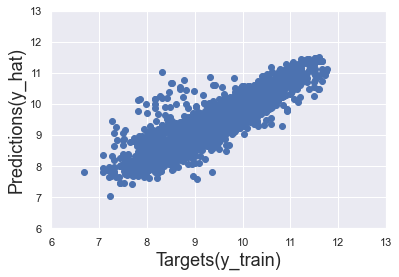

In [11]:
plt.scatter(y_train,y_hat)
plt.xlabel('Targets(y_train)', size=18)
plt.ylabel('Predictions(y_hat)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Distribution of Training Residual')

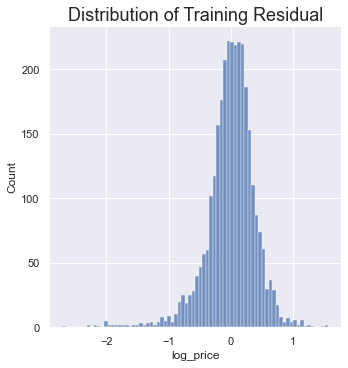

In [20]:
sns.displot(y_train-y_hat)
plt.title('Distribution of Training Residual', size=18)

## Assumptions on test data

In [13]:
def residuals(model, x, y):
    y_hat_test = model.predict(x_poly_test)
    residuals = y_test-y_hat_test
    return pd.DataFrame({'Targets': y_test, 'Predictions': y_hat_test, 'Residuals': residuals})

In [14]:
def autocorrelation_assumption(model, x_test, y_test):
    autocorrelresults = residuals(model, x_test, y_test)
    durbinWatson = durbin_watson(autocorrelresults['Residuals'])
    print('Durbin-Watson:', round(durbinWatson,3))
    if durbinWatson < 1.5:
        print('Sings of positive autocorrelation. Assumption not satisfied.', '\n')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation. Assumption not satisfied.', '\n')
    else:
        print('Little to no correlation','\n')

In [15]:
autocorrelation_assumption(model, x_poly_test, y_test)

Durbin-Watson: 2.091
Little to no correlation 



## Model Evaluation

In [16]:
def model_evaluation(model, x_test, y_test, model_name):
    y_hat_test = model.predict(x_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_hat_test)
    MSE = metrics.mean_squared_error(y_test, y_hat_test)
    RMSE = np.sqrt(MSE)
    R2_score = metrics.r2_score(y_test, y_hat_test)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_score], index=['MAE', 'MSE', 'RMSE', 'R2_score'], columns=[model_name])

In [17]:
# Model performance on Test data.
model_evaluation(model, x_poly_test, y_test, 'Polynomial Reg Test')

,Polynomial Reg Test
MAE,0.308819
MSE,0.205866
RMSE,0.453725
R2_score,0.750219


In [18]:
# Model performance on training data
model_evaluation(model, x_poly_train, y_train, 'Polynomial Reg Train')

,Polynomial Reg Train
MAE,0.282535
MSE,0.159755
RMSE,0.399694
R2_score,0.787945


In [19]:
# Model evaluation using cross-validation

#load the data
x = scaled_inputs
y = targets
#define the pipeline
pipeline = make_pipeline(PolynomialFeatures(degree = 2), StandardScaler(), LinearRegression())
# Define cross-validation strategy
kf = KFold(n_splits =6, shuffle=True, random_state=42)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
# perform cross-validation
result = cross_validate(pipeline, x, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
r2_score_mean = result['test_r2'].mean()
r2_score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,r2_score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,r2_score_std]}, index=[ 'MAE', 'MSE', 'RMSE', 'R2_Score'])

,Mean,Std
MAE,9.204965e+08,2.058293e+09
MSE,3.279105e+21,7.332301e+21
RMSE,2.337771e+10,5.227415e+10
R2_Score,-4.028917e+21,9.008932e+21
